In [1]:
!nvidia-smi

Wed Nov 29 14:16:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 48.2 MB/s eta 0:00:00


In [3]:
import mediapipe

In [4]:
import cv2
import os

from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

from pathlib import Path

from torchvision import transforms
import torch
import random

import zipfile
from shutil import make_archive, rmtree

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
from google.colab import output

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
mp_face_mesh = mediapipe.solutions.face_mesh

In [10]:
RIGHT_IRIS = [474, 475, 476, 477]
LEFT_IRIS = [469, 470, 471, 472]
R_H_LEFT = [33]  # right eye right most landmark
R_H_RIGHT = [133]  # right eye left most landmark
R_H_PUPIL = [468]
L_H_LEFT = [362]  # left eye right most landmark
L_H_RIGHT = [263]  # left eye left most landmark
L_H_PUPIL = [473]
R_H_TOP = [158, 159]
R_H_BOTTOM = [145]
L_H_TOP = [385, 386]
L_H_BOTTOM = [374]

In [11]:
OUTPUT_PATH = './Data_collection_1280x720'

In [13]:
def get_eyes(frame, numpy_shapes, is_square, w_coef, h_coef):
    eyes = []
    eyes_coords = []
    for eye_point in [36, 42]:
        x1, y1 = np.amin(numpy_shapes[eye_point:eye_point+6], axis=0)
        x2, y2 = np.amax(numpy_shapes[eye_point:eye_point+6], axis=0)
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        w = (x2 - x1) * w_coef
        h = w if is_square else (y2 - y1) * h_coef
        margin_x, margin_y = w / 2, h / 2
        min_x, min_y = int(cx - margin_x), int(cy - margin_y)
        max_x, max_y = int(cx + margin_x), int(cy + margin_y)
        eye_rect = np.rint([min_x, max_x, min_y, max_y]).astype(int)
        eyes.append(eye_rect)
    return eyes, numpy_shapes[36], numpy_shapes[39], numpy_shapes[45], numpy_shapes[42]

def create_frames(input_path, is_square=False, w_coef=2, h_coef=2):
    images_list = list(Path(input_path).rglob('*.jpg'))
    csv_path = list(Path(input_path).rglob('*.csv'))[0]
    point_map = np.zeros((900, 1600))
    segment_map = np.zeros((3, 4))
    if not len(images_list) > 1:
        return map
    csv_data = pd.read_csv(csv_path).reset_index()
    input_coords_df = pd.DataFrame(columns=['jpg_name',
                                            'left_inner_x',
                                            'left_outer_x',
                                            'left_inner_y',
                                            'left_outer_y',
                                            'right_inner_x',
                                            'right_outer_x',
                                            'right_inner_y',
                                            'right_outer_y',
                                            'left_pupil_x',
                                            'left_pupil_y',
                                            'right_pupil_x',
                                            'right_pupil_y',
                                            'left_pupil_as_center_x',
                                            'left_pupil_as_center_y',
                                            'right_pupil_as_center_x',
                                            'right_pupil_as_center_y',
                                            'target_x_norm',
                                            'target_y_norm',
                                            'target_x',
                                            'target_y',
                                            'screen_segment'])
    with mp_face_mesh.FaceMesh(
                max_num_faces=1,
                refine_landmarks=True,
                min_detection_confidence=0.65, #0.65 and 0.65
                min_tracking_confidence=0.65) as face_mesh:
        counter = 0
        for img in images_list:
            frame = cv2.imread(str(img))
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = face_mesh.process(rgb_frame)
            if not res.multi_face_landmarks:
                csv_data = csv_data[csv_data['jpg_name'] != str(img).split('/')[-1]].reset_index(drop=True)
                os.remove(str(img))
                print(str(img).split('/')[-1]+' deleted, face not found')
                counter +=1
            else:
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                h, w = frame.shape[:2]
                norm_meshpoints = np.array([np.array([p.x, p.y]) for p in res.multi_face_landmarks[0].landmark])
                meshpoints = np.array([np.array([p.x*w, p.y*h]).astype(int) for p in res.multi_face_landmarks[0].landmark])
                l_l_corner_darker = gray_frame[meshpoints[L_H_PUPIL][0,1], meshpoints[L_H_PUPIL][0,0]] > gray_frame[meshpoints[L_H_LEFT][0,1], meshpoints[L_H_LEFT][0,0]]
                l_r_corner_darker = gray_frame[meshpoints[L_H_PUPIL][0,1], meshpoints[L_H_PUPIL][0,0]] > gray_frame[meshpoints[L_H_RIGHT][0,1], meshpoints[L_H_RIGHT][0,0]]
                r_l_corner_darker = gray_frame[meshpoints[R_H_PUPIL][0,1], meshpoints[R_H_PUPIL][0,0]] > gray_frame[meshpoints[R_H_LEFT][0,1], meshpoints[R_H_LEFT][0,0]]
                r_r_corner_darker = gray_frame[meshpoints[R_H_PUPIL][0,1], meshpoints[R_H_PUPIL][0,0]] > gray_frame[meshpoints[R_H_RIGHT][0,1], meshpoints[R_H_RIGHT][0,0]]
                r_pupil_error = frame[meshpoints[R_H_PUPIL][0,1], meshpoints[R_H_PUPIL][0,0],2] > 100
                l_pupil_error = frame[meshpoints[L_H_PUPIL][0,1], meshpoints[L_H_PUPIL][0,0],2] > 100
                if (l_l_corner_darker and l_r_corner_darker) or (r_r_corner_darker and r_l_corner_darker) or round(float(csv_data[csv_data['jpg_name']==str(img).split('/')[-1]].reset_index(drop=True).loc[0, 'x_norm'])*1600)==-1600: #r_pupil_error or l_pupil_error:
                    os.remove(str(img))
                    print(str(img).split('/')[-1]+' deleted, pupils not found '+
                          str(round(float(csv_data[csv_data['jpg_name']==str(img).split('/')[-1]].reset_index(drop=True).loc[0, 'x_norm'])*1600))+" "+
                          str(round(float(csv_data[csv_data['jpg_name']==str(img).split('/')[-1]].reset_index(drop=True).loc[0, 'y_norm'])*900)))
                    csv_data = csv_data[csv_data['jpg_name'] != str(img).split('/')[-1]].reset_index(drop=True)
                    counter +=1
                    continue
                print(str(img).split('/')[-1]+' accepted')
                (l_cx, l_cy), l_radius = cv2.minEnclosingCircle(meshpoints[LEFT_IRIS])
                (r_cx, r_cy), r_radius = cv2.minEnclosingCircle(meshpoints[RIGHT_IRIS])
                center_left = np.array([l_cx, l_cy], dtype=np.int32)
                center_right = np.array([r_cx, r_cy], dtype=np.int32)
                tx = round(float(csv_data[csv_data['jpg_name']==str(img).split('/')[-1]].reset_index(drop=True).loc[0, 'x_norm'])*1600)
                ty = round(float(csv_data[csv_data['jpg_name']==str(img).split('/')[-1]].reset_index(drop=True).loc[0, 'y_norm'])*900)
                label = tx//400+ty//300*4 if tx != -1 and ty != -1 else 12
                if tx != -1600 and ty != -900:
                    point_map[ty,tx]+=255
                    segment_map[ty//300, tx//400] += 100
                #cv2.circle(frame, center_right, int(r_radius), (255,255,255), 1, cv2.LINE_AA)
                #cv2.circle(frame, center_left, int(l_radius), (255,0,255), 1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[R_H_RIGHT][0], 2, (255,0,0), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[R_H_LEFT][0], 2, (255,0,0), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[L_H_RIGHT][0], 2, (0,255,255), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[L_H_LEFT][0], 2, (0,255,255), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[L_H_PUPIL][0], 1, (0,255,255), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[R_H_PUPIL][0], 1, (255,0,0), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[R_H_BOTTOM][0], 1, (255,0,0), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[L_H_BOTTOM][0], 1, (0,255,255), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[R_H_TOP][0], 1, (255,0,0), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[L_H_TOP][0], 1, (0,255,255), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[R_H_TOP][1], 1, (255,0,0), -1, cv2.LINE_AA)
                #cv2.circle(frame, meshpoints[L_H_TOP][1], 1, (0,255,255), -1, cv2.LINE_AA)
                #cv2.imwrite(str(img), frame)
                new_df = pd.DataFrame({'jpg_name': str(img).split('/')[-1],
                                       'right_inner_x':norm_meshpoints[R_H_LEFT][0,0],
                                       'right_inner_y':norm_meshpoints[R_H_LEFT][0,1],
                                       'left_inner_x':norm_meshpoints[L_H_RIGHT][0,0],
                                       'left_inner_y':norm_meshpoints[L_H_RIGHT][0,1],
                                       'right_outer_x':norm_meshpoints[R_H_RIGHT][0,0],
                                       'right_outer_y':norm_meshpoints[R_H_RIGHT][0,1],
                                       'left_outer_x':norm_meshpoints[L_H_LEFT][0,0],
                                       'left_outer_y':norm_meshpoints[L_H_LEFT][0,1],
                                       'left_pupil_x':norm_meshpoints[L_H_PUPIL][0,0],
                                       'left_pupil_y':norm_meshpoints[L_H_PUPIL][0,1],
                                       'right_pupil_x':norm_meshpoints[R_H_PUPIL][0,0],
                                       'right_pupil_y':norm_meshpoints[R_H_PUPIL][0,1],
                                       'left_pupil_as_center_x':center_left[0],
                                       'left_pupil_as_center_y':center_left[1],
                                       'right_pupil_as_center_x':center_right[0],
                                       'right_pupil_as_center_y':center_right[1],
                                       'target_x_norm':csv_data[csv_data['jpg_name']==str(img).split('/')[-1]].reset_index(drop=True).loc[0, 'x_norm'],
                                       'target_y_norm':csv_data[csv_data['jpg_name']==str(img).split('/')[-1]].reset_index(drop=True).loc[0, 'y_norm'],
                                       'target_x':tx,
                                       'target_y':ty,
                                       'screen_segment':label
                                       },  index=[0])
                input_coords_df = pd.concat([input_coords_df, new_df], ignore_index=True)
        input_coords_df.reset_index(drop=True).to_csv(input_path+"/target_data.csv")
        print(f'deleted {counter} files')
    return point_map, segment_map

In [14]:
!rm -R ./Data_collection*

rm: cannot remove './Data_collection*': No such file or directory


In [15]:
if (os.path.isfile('/content/drive/MyDrive/Data_collection_1280x720.zip') and not os.path.isdir('./Data_collection_1280x720')):
    zipfile.ZipFile('/content/drive/MyDrive/Data_collection_1280x720.zip', 'r').extractall('./')

In [16]:
pmap, smap = create_frames(OUTPUT_PATH)

Выходные данные были обрезаны до нескольких последних строк (5000).
1700911886039.jpg accepted
1700908993783.jpg accepted
1700996900081.jpg deleted, pupils not found -1600 -900
1700913517247.jpg accepted
1700909761573.jpg accepted
1700916674137.jpg accepted
1700996789401.jpg accepted
1700999021190.jpg accepted
1700907984462.jpg accepted
1700996766379.jpg accepted
1700915678695.jpg deleted, pupils not found 1036 895
1700908022345.jpg deleted, pupils not found 1332 212
1700908869095.jpg accepted
1700908459236.jpg deleted, pupils not found -1600 -900
1700908422483.jpg accepted
1701198837095.jpg deleted, pupils not found 772 127
1700996754663.jpg accepted
1700913666783.jpg accepted
1700923499632.jpg accepted
1700995318642.jpg accepted
1700908775840.jpg deleted, pupils not found 1070 426
1700997178274.jpg accepted
1700911773652.jpg accepted
1700912260464.jpg accepted
1700908320791.jpg accepted
1700915701718.jpg accepted
1700909919493.jpg accepted
1700908219723.jpg deleted, pupils not found 

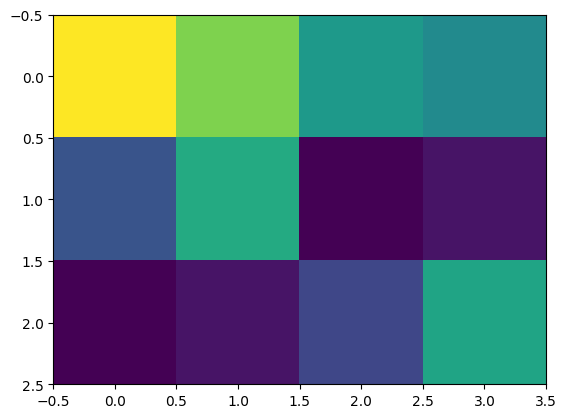

In [17]:
plt.imshow(smap)

In [18]:
list(Path(OUTPUT_PATH).rglob('*.csv'))

[PosixPath('Data_collection_1280x720/target_data.csv'),
 PosixPath('Data_collection_1280x720/coords.csv')]

In [19]:
images_list = list(Path(OUTPUT_PATH).rglob('*.jpg'))
train_val_imgs, test_imgs = train_test_split(images_list, test_size=0.05, shuffle=True)
train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=0.05, shuffle=True)

In [20]:
class EyeTrackingDataset(Dataset):
    def __init__(self, images_path, size_list):
        super().__init__()
        self.images_path = sorted(images_path)
        self.len_ = len(self.images_path)
        self.size_list = size_list

    def __len__(self):
        return self.len_

    def load_data(self, file):
        full_image = cv2.imread(file)
        h,w = full_image.shape[:2]
        path_to_input_coords = OUTPUT_PATH+'/target_data.csv'
        input_coords = pd.read_csv(path_to_input_coords)
        input_coords = input_coords[input_coords['jpg_name'] == file.split('/')[-1]].reset_index(drop=True)
        left_inner_x = input_coords.loc[0, 'left_inner_x']
        left_inner_y = input_coords.loc[0,'left_inner_y']
        right_inner_x = input_coords.loc[0,'right_inner_x']
        right_inner_y = input_coords.loc[0,'right_inner_y']
        left_outer_x = input_coords.loc[0, 'left_outer_x']
        left_outer_y = input_coords.loc[0,'left_outer_y']
        right_outer_x = input_coords.loc[0,'right_outer_x']
        right_outer_y = input_coords.loc[0,'right_outer_y']
        left_pupil_x = input_coords.loc[0,'left_pupil_x']
        left_pupil_y = input_coords.loc[0,'left_pupil_y']
        right_pupil_x = input_coords.loc[0,'right_pupil_x']
        right_pupil_y = input_coords.loc[0,'right_pupil_y']
        left_pupil_as_center_x = input_coords.loc[0,'left_pupil_as_center_x'] / w
        left_pupil_as_center_y = input_coords.loc[0,'left_pupil_as_center_y'] / h
        right_pupil_as_center_x = input_coords.loc[0,'right_pupil_as_center_x'] / w
        right_pupil_as_center_y = input_coords.loc[0,'right_pupil_as_center_y'] / h
        left_eye = full_image[int(left_pupil_y*h-w*abs(left_outer_x-left_inner_x)/2):int(left_pupil_y*h+w*abs(left_outer_x-left_inner_x)/2),
                              int(left_outer_x*w):int(left_inner_x*w)]
        right_eye = full_image[int(right_pupil_y*h-w*abs(right_inner_x-right_outer_x)/2):int(right_pupil_y*h+w*abs(right_inner_x-right_outer_x)/2),
                              int(right_inner_x*w):int(right_outer_x*w)]
        return [cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB),
                cv2.flip(cv2.cvtColor(left_eye, cv2.COLOR_BGR2RGB), 1),
                cv2.cvtColor(right_eye, cv2.COLOR_BGR2RGB),
                left_pupil_as_center_x,
                left_pupil_as_center_y,
                right_pupil_as_center_x,
                right_pupil_as_center_y,
                left_pupil_x,
                left_pupil_y,
                right_pupil_x,
                right_pupil_y,
                left_inner_x,
                left_inner_y,
                right_inner_x,
                right_inner_y,
                left_outer_x,
                left_outer_y,
                right_outer_x,
                right_outer_y,
                input_coords.loc[0,'target_x_norm'],
                input_coords.loc[0,'target_y_norm'],
                input_coords.loc[0,'screen_segment']]

    def __getitem__(self, index):
        data = self.load_data(str(self.images_path[index]))
        coords_tensors = []
        for i in range(3):
            data[i] = np.array(data[i] / 255, dtype='float32')
            data[i] = self.prepare_data(data[i], self.size_list[i])
        for i in range(3,len(data)-1,2):
            data[i] = np.array(data[i], dtype='float32')
            data[i+1] = np.array(data[i+1], dtype='float32')
            coords_tensors.append(torch.cat((torch.Tensor(data[i]).unsqueeze(-1), torch.Tensor(data[i+1]).unsqueeze(-1)), dim=-1))
        return [str(self.images_path[index]), data[0:3], coords_tensors, data[-1]]

    def prepare_data(self, image, sizes=None):
        transform = transforms.Compose([
            transforms.ColorJitter(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        if sizes is not None:
            image = cv2.resize(image, sizes, interpolation = cv2.INTER_AREA)
        image = transform(image)
        return image

In [21]:
train_dataset = EyeTrackingDataset(train_imgs, [(1280, 720), (128, 128), (128, 128)])
val_dataset = EyeTrackingDataset(val_imgs, [(1280, 720), (128, 128), (128, 128)])
test_dataset = EyeTrackingDataset(test_imgs, [(1280, 720), (128, 128), (128, 128)])

In [22]:
len(train_dataset)

3603

In [23]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

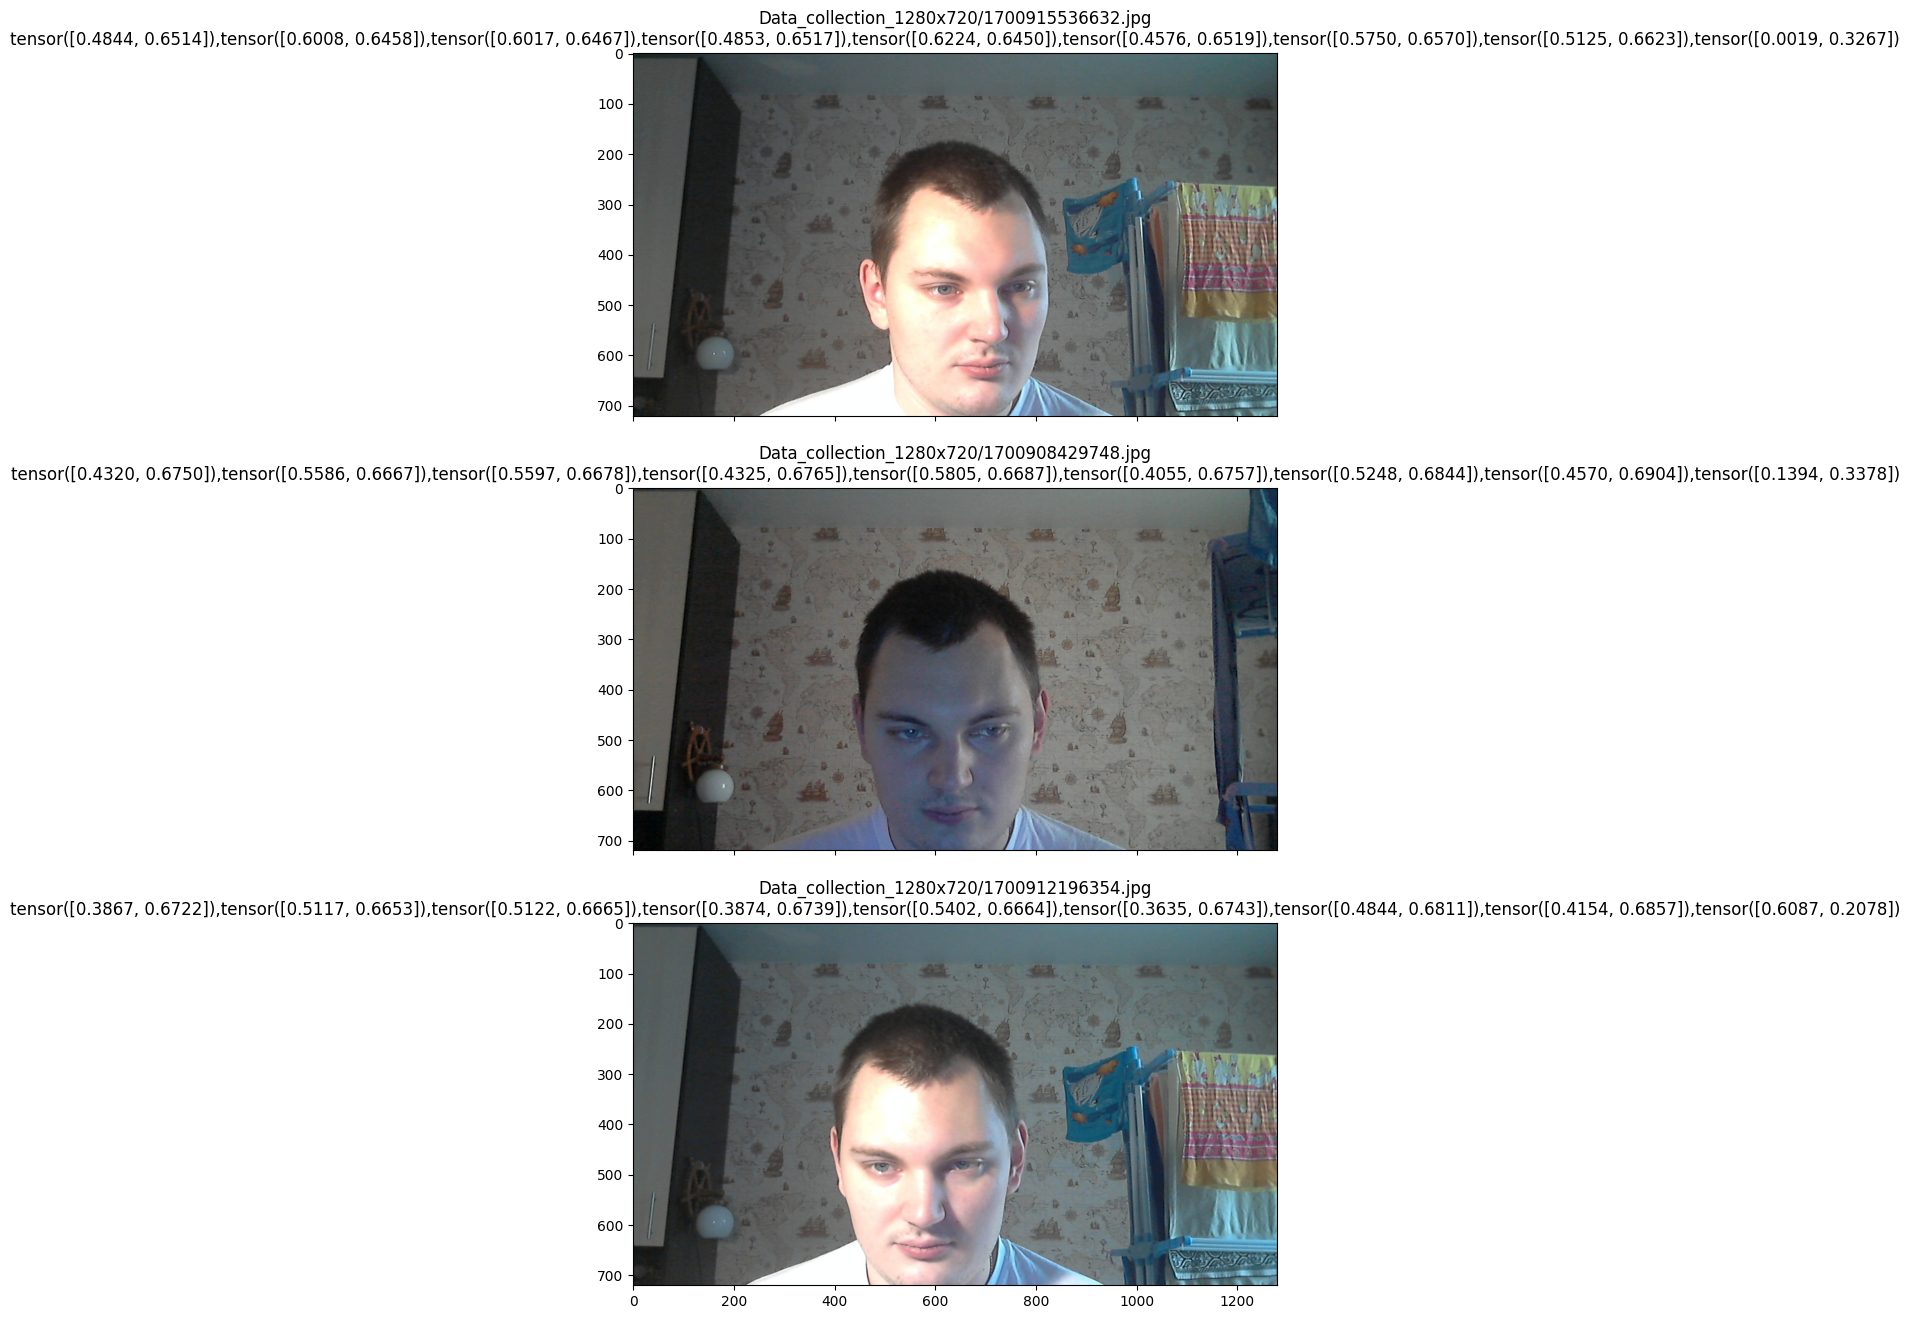

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(16, 16), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(train_dataset)))
    file, imgs, coords, segment = train_dataset[random_characters]
    coord_title = file+'\n'+','.join([str(_) for _ in coords])
    imshow(imgs[0].data.cpu(), title=coord_title, plt_ax=fig_x)

In [25]:
BATCH_SIZE = 32
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
               'test': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train':len(train_dataset),
               'val': len(val_dataset),
               'test': len(test_dataset)}

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [27]:
import time

In [28]:
def train_model(model, criterion, optimizer, scheduler, wts_path, num_epochs=25, model_name='baseline'):
    since = time.time()
    best_model_wts = model.state_dict()
    best_loss = np.inf
    losses = {'train': [], "val": []}
    for epoch in range(num_epochs):
        plt.close()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()
            running_loss = 0.0
            for data in dataloaders[phase]:
                _, imgs, coords, _ = data
                imgs = [img.to(device) for img in imgs[1:]]
                coords = [coord.to(device) for coord in coords]
                if phase=="train":
                    optimizer.zero_grad()

                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(imgs, coords[:-1])
                else:
                    outputs = model(imgs, coords[:-1])
                loss = criterion(outputs, coords[-1])
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * coords[0].size(0)
            if phase=='train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            with open('./losses_'+phase+'_'+model_name, 'w') as loss_file:
                loss_file.write(' '.join([str(loss_value) for loss_value in losses[phase]]))
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, './best_'+wts_path.split('/')[1])
        output.clear()
        plt.figure(figsize=(12, 8))
        epochs = [_ for _ in range(1,epoch+2)]
        time_elapsed = time.time() - since
        plt.title('Epoch '+str(epoch+1)+', elapsed time: '+str(time_elapsed/60))
        if epoch>=1:
            plt.plot(epochs, losses['train'], label='train')
            plt.plot(epochs, losses['val'], label='val')
        else:
            plt.scatter(epochs, losses['train'], label='train')
            plt.scatter(epochs, losses['val'], label='val')
        plt.legend()
        plt.show()
    torch.save(model.state_dict(), './last_'+wts_path.split('/')[1])
    return model, losses

In [31]:
class OneEyeNetAsRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.first_eye = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU())
        self.coords = torch.nn.Sequential(
            torch.nn.Linear(in_features=6, out_features=128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=16),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU())
        self.union = torch.nn.Sequential(
            torch.nn.Linear(in_features=16+2048, out_features=8),
            torch.nn.BatchNorm1d(8),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=8, out_features=4),
            torch.nn.BatchNorm1d(4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=4, out_features=2),
            torch.nn.ReLU())

    def forward(self, imgs, coords):
        x_1 = self.first_eye(imgs[1])
        x_1 = x_1.reshape(x_1.shape[0], -1)
        x_2 = self.coords(torch.cat(tuple([coords[3],coords[5],coords[7]]), dim=-1))
        return self.union(torch.cat((x_1, x_2), dim=-1))

In [32]:
def init_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = OneEyeNetAsRegression().to(device)
model.apply(init_weights)
print(sum(p.numel() for p in model.parameters()))

150446


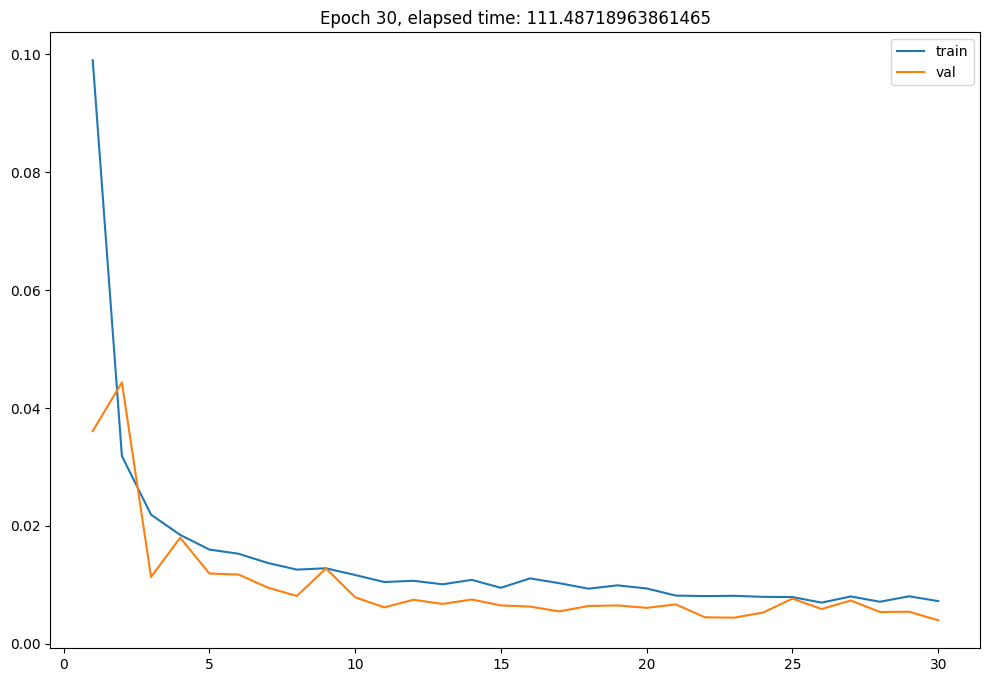

In [33]:
N_EPOCHS = 30
WTS_PATH = './one_eye.pt'#'D:/dataset semeov/best.pt'
optimizer = torch.optim.Adam(model.parameters(), lr=0.016)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.64)
criterion = torch.nn.MSELoss()
model, losses = train_model(model, criterion, optimizer, lr_scheduler, WTS_PATH, num_epochs=N_EPOCHS, model_name='one_eye')

In [35]:
def evaluate_test(model, criterion, phase='test'):
    sum_loss = 0
    model.eval()
    with torch.no_grad():
        for i in range(len(test_dataset)):
            _, imgs, coords, segment = test_dataset[i]
            imgs = [img.unsqueeze(0).to(device) for img in imgs[1:]]
            coords = [coord.unsqueeze(0).to(device) for coord in coords]
            outputs = model(imgs, coords[:-1])
            outputs[:,0] = outputs[:,0] * 1600
            outputs[:,1] = outputs[:,1] * 900
            coords[-1][:,0] = coords[-1][:,0] * 1600
            coords[-1][:,1] = coords[-1][:,1] * 900
            loss = criterion(outputs, coords[-1])
            sum_loss += loss.item()
    return sum_loss / len(test_dataset)

In [36]:
criterion = torch.nn.MSELoss(reduction='sum')
evaluate_test(model, criterion)

27134.890799751283

tensor([530., 696.], device='cuda:0') tensor([[  2., 492.]], device='cuda:0')


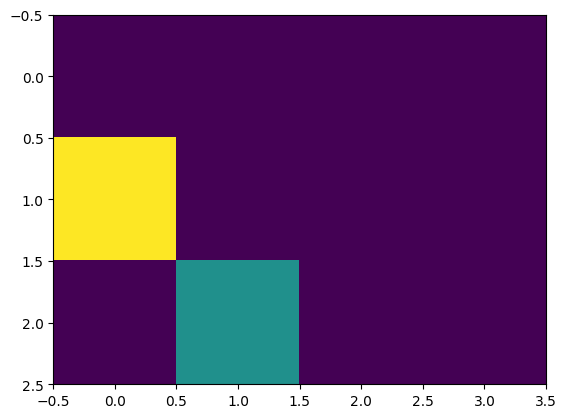

In [50]:
model.eval()
smap = np.zeros((3,4))
with torch.no_grad():
    random_character = int(np.random.uniform(0,len(test_dataset)))
    file, imgs, coords, segment = test_dataset[random_character]
    #print(segment)
    smap[segment//4, segment%4] += 100
    imgs = [img.unsqueeze(0).to(device) for img in imgs]
    coords = [coord.unsqueeze(0).to(device) for coord in coords]
    outputs = model(imgs, coords[:-1]).squeeze()
    outputs[0] = abs(torch.round(1600*outputs[0]))
    outputs[1] = abs(torch.round(900*outputs[1]))
    coords[-1][0][0] = abs(torch.round(1600*coords[-1][0][0]))
    coords[-1][0][1] = abs(torch.round(900*coords[-1][0][1]))
    print(outputs, coords[-1])
    smap[min(899,int(outputs[1]))//300,min(1599,int(outputs[0]))//400] += 50
plt.imshow(smap)

<BarContainer object of 12 artists>

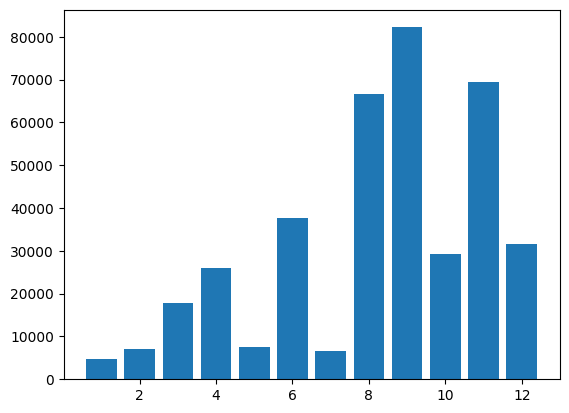

In [46]:
model.eval()
sample_nums = torch.zeros((12))
sum_mse = torch.zeros((12))
for i in range(len(test_dataset)):
    file, imgs, coords, segment = test_dataset[i]
    imgs = [img.unsqueeze(0).to(device) for img in imgs[1:]]
    coords = [coord.unsqueeze(0).to(device) for coord in coords]
    with torch.no_grad():
        outputs = model(imgs, coords[:-1]).squeeze()
        outputs[0] = abs(torch.round(1600*outputs[0]))
        outputs[1] = abs(torch.round(900*outputs[1]))
        coords[-1][0][0] = abs(torch.round(1600*coords[-1][0][0]))
        coords[-1][0][1] = abs(torch.round(900*coords[-1][0][1]))
        sum_mse[segment] += criterion(outputs, coords[-1][0]).item()
        sample_nums[segment] += 1
bar_data = torch.div(sum_mse, sample_nums).detach().cpu().numpy()
plt.bar([_ for _ in range(1,13)], bar_data)